# The simple model 8: Grid Search по Behler-Parrinello

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from itertools import product
import os
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

!pip install matminer
!pip install pymatgen
!pip install maml
!git clone https://github.com/bvd757/3DSC.git

from pymatgen.core.structure import Structure
from maml.describers import BPSymmetryFunctions

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/aimat-lab/3DSC/main/superconductors_3D/data/final/MP/3DSC_MP.csv', header = 1)
data_t = data[['tc']]
data

from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.conversions import StrToComposition
ep_feat = ElementProperty.from_preset(preset_name="magpie")
d = {"element": np.array(data)[:, 0]}
df = pd.DataFrame(d)

df = StrToComposition().featurize_dataframe(df, "element")
df = ep_feat.featurize_dataframe(df, col_id = 'composition')

df["g1"] = np.zeros(len(df))
df["g2"] = np.zeros(len(df))
df["g3"] = np.zeros(len(df))
df["g4"] = np.zeros(len(df))
df["g5"] = np.zeros(len(df))
df["g6"] = np.zeros(len(df))
df["g7"] = np.zeros(len(df))
df["g8"] = np.zeros(len(df))
df

In [3]:
df

,element,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,...,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,g1,g2,g3,g4,g5,g6,g7,g8
0,Ag0.02Ge2Pd1.98Sr1,"(Ag, Ge, Pd, Sr)",32.0,47.0,15.0,38.804000,5.764800,32.0,8.0,79.0,...,0.000000,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ag0.15Sn0.85Te1,"(Ag, Sn, Te)",47.0,52.0,5.0,50.775000,1.225000,52.0,65.0,90.0,...,10.830000,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ag0.1Ge2Pd1.9Sr1,"(Ag, Ge, Pd, Sr)",32.0,47.0,15.0,38.820000,5.784000,32.0,8.0,79.0,...,0.000000,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ag0.1In0.9Te1,"(Ag, In, Te)",47.0,52.0,5.0,50.400000,1.600000,52.0,65.0,90.0,...,9.720000,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ag0.2Ba1Si1.8,"(Ag, Ba, Si)",14.0,56.0,42.0,30.200000,19.440000,14.0,9.0,78.0,...,0.977778,227.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5768,Y1Zn1,"(Y, Zn)",30.0,39.0,9.0,34.500000,4.500000,30.0,12.0,69.0,...,0.000000,194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5769,Yb1,(Yb),70.0,70.0,0.0,70.000000,0.000000,70.0,39.0,39.0,...,0.000000,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5770,Zn1,(Zn),30.0,30.0,0.0,30.000000,0.000000,30.0,69.0,69.0,...,0.000000,194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5771,Zn2Zr1,"(Zn, Zr)",30.0,40.0,10.0,33.333333,4.444444,30.0,44.0,69.0,...,0.000000,194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
discryper = BPSymmetryFunctions(cutoff = 6.0, r_etas = np.array([4]), r_shift = np.array([4]), a_etas = np.array([4]), 
                                zetas = np.array([4]), lambdas = np.array([1, -1]), feature_batch = 'pandas_concat')
p = pow(10, 10)
df1 = df.copy()
data_t1 = data_t.copy()
l = len(df1)
for i in enumerate(os.listdir(path="/content/3DSC/superconductors_3D/data/final/MP/cifs")):
    #print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n", i[1], "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n")
    cif = Structure.from_file("/content/3DSC/superconductors_3D/data/final/MP/cifs/" + i[1])
    if i[1][:i[1].find('-MP')] not in df1['element'].to_list(): continue
    j = df.loc[df['element'] == i[1][:i[1].find('-MP')]].index
    b = True
    while b: #Повторять пока b = True
        try:
            cit = discryper.transform_one(cif)
            df1['g1'][j] = (cit[0] * p).mean()
            df1['g2'][j] = (cit[1] * p).mean()
            df1['g3'][j] = (cit[2] * p).mean()
            df1['g4'][j] = (cit[3] * p).mean()
            df1['g5'][j] = (cit[4] * p).mean()
            df1['g6'][j] = (cit[5] * p).mean()
            df1['g7'][j] = (cit[6] * p).mean()
            df1['g8'][j] = (cit[7] * p).mean()
            
            b = False # если все хорошо прерываем цикл while
        except Exception: # иначе выполнится исключение и b останется True
            df1.drop(labels=j, axis=0, inplace=True)
            data_t1.drop(labels=j, axis=0, inplace=True)
            break

In [107]:
def plot_features_scores(model, data, target, column_names, model_type):
    '''Функция для визуализации важности признаков'''
    
    model.fit(data, target)
    
    if model_type == 'rf':
        (pd.DataFrame(data={'score': model['rf'].feature_importances_}, 
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
    elif model_type == 'lr':
        (pd.DataFrame(data={'score': model['lr'].coef_[0]},
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
        
    else:
        raise KeyError('Unknown model_type')

In [150]:
def GS(df, data_t, r_etas, r_shift, a_etas, zetas):
    discryper = BPSymmetryFunctions(cutoff = 6, r_etas = r_etas, r_shift = r_shift, a_etas = a_etas, 
                                zetas = zetas, lambdas = np.array([1, -1]), feature_batch = 'pandas_concat')

    
    p = pow(10, 10)
    df1 = df.copy()
    data_t1 = data_t.copy()
    l = len(df1)
    for i in enumerate(os.listdir(path="/content/3DSC/superconductors_3D/data/final/MP/cifs")):
        if i[0] == l: break
        #print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n", i[1], "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n")
        cif = Structure.from_file("/content/3DSC/superconductors_3D/data/final/MP/cifs/" + i[1])
        if i[1][:i[1].find('-MP')] not in df1['element'].to_list(): continue
        j = df.loc[df['element'] == i[1][:i[1].find('-MP')]].index
        b = True
        while b: #Повторять пока b = True
            try:
                cit = discryper.transform_one(cif)
                df1['g1'][j] = (cit[0] * p).mean()
                df1['g2'][j] = (cit[1] * p).mean()
                df1['g3'][j] = (cit[2] * p).mean()
                df1['g4'][j] = (cit[3] * p).mean()
                df1['g5'][j] = (cit[4] * p).mean()
                df1['g6'][j] = (cit[5] * p).mean()
                df1['g7'][j] = (cit[6] * p).mean()
                df1['g8'][j] = (cit[7] * p).mean()
            
                b = False # если все хорошо прерываем цикл while
            except Exception: # иначе выполнится исключение и b останется True
                df1.drop(labels=j, axis=0, inplace=True)
                data_t1.drop(labels=j, axis=0, inplace=True)
                break


    i = df1.loc[(df1['g1'] + df1['g2'] + df1['g3'] + df1['g4'] + df1['g5'] + df1['g6'] + df1['g7'] + df1['g8']) != 0].index
    df2 = df1.loc[i]
    df2 = df2[['MagpieData mean AtomicWeight', 'MagpieData mean MeltingT',
'MagpieData mean Electronegativity', 'MagpieData mean NdValence', 'MagpieData mean GSvolume_pa', 
'MagpieData mean SpaceGroupNumber', 'MagpieData mean NdUnfilled', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8']]
    data_t2 = data_t1.loc[i]
    df2 = (df2 - df2.mean()) / df2.std()

    df2_ = df2[['MagpieData mean AtomicWeight', 'MagpieData mean MeltingT',
'MagpieData mean Electronegativity', 'MagpieData mean NdValence', 'MagpieData mean GSvolume_pa', 
'MagpieData mean SpaceGroupNumber', 'MagpieData mean NdUnfilled']]

    X_train, X_test, y_train, y_test = train_test_split(df2, data_t2, test_size=0.2, random_state=85)
    rfr1 = RandomForestRegressor(max_features = 'log2', min_samples_split = 8, bootstrap = True, n_estimators = 100)
    rfr1.fit(X_train, y_train.values.ravel())
    score = cross_val_score(rfr1, X_test, y_test, scoring='neg_mean_squared_error', cv = 5)
    score = score[np.isfinite(score)]
    rf = Pipeline([('rf', rfr1)])
    # параметры кросс-валидации (стратифицированная 5-фолдовая с перемешиванием) 

    scores = cross_val_score(estimator=rf, X=X_test, y=y_test, scoring='neg_mean_squared_error', n_jobs=-1)
    # важность признаков
    plot_features_scores(model=rf, data=X_test, target=y_test, column_names=X_test.columns, model_type='rf')


    X_train, X_test, y_train, y_test = train_test_split(df2_, data_t2, test_size=0.2, random_state=85)
    rfr1 = RandomForestRegressor(max_features = 'log2', min_samples_split = 8, bootstrap = True, n_estimators = 100)
    rfr1.fit(X_train, y_train.values.ravel())
    score_ = cross_val_score(rfr1, X_test, y_test, scoring='neg_mean_squared_error', cv = 5)
    score_ = score_[np.isfinite(score_)]

    return len(df2), [score.mean(), score.std()], [score_.mean(), score_.std()]
    


________________
O_______________
OO______________
OOO_____________
OOOO____________
OOOOO___________
OOOOOO__________
OOOOOOO_________
OOOOOOOO________
OOOOOOOOO_______
OOOOOOOOOO______
OOOOOOOOOOO_____
OOOOOOOOOOOO____
OOOOOOOOOOOOO___
OOOOOOOOOOOOOO__
OOOOOOOOOOOOOOO_
OOOOOOOOOOOOOOOO


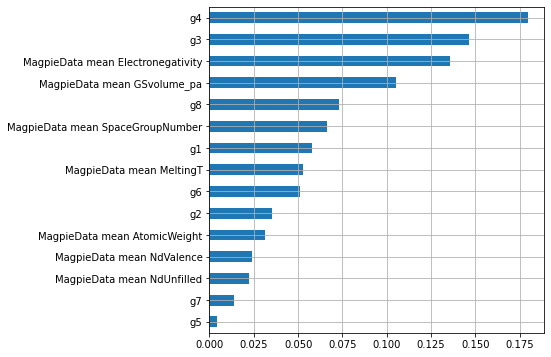

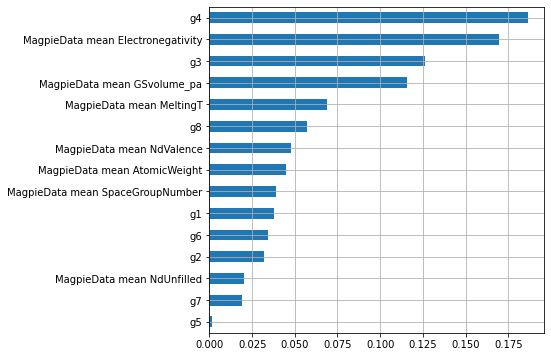

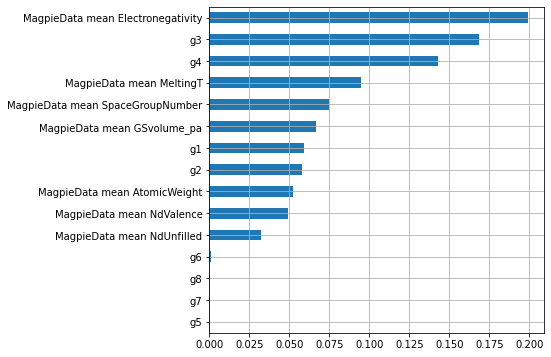

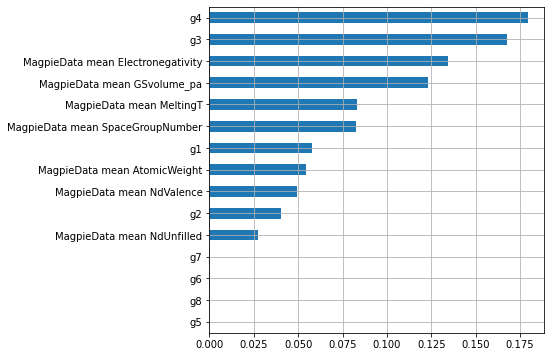

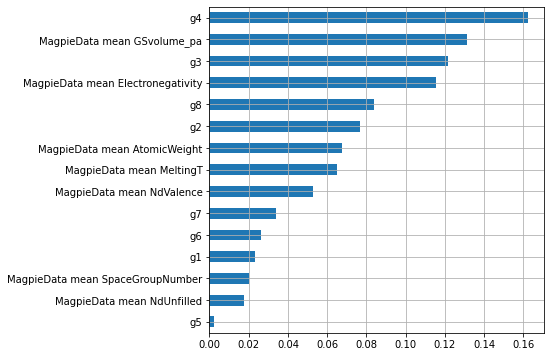

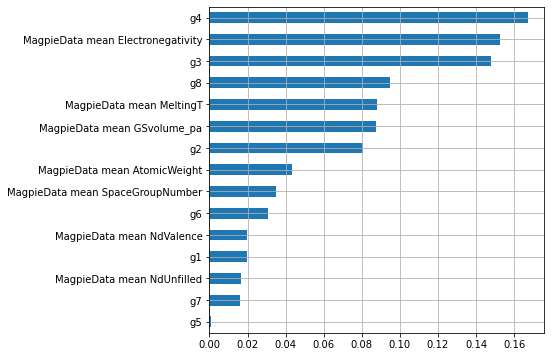

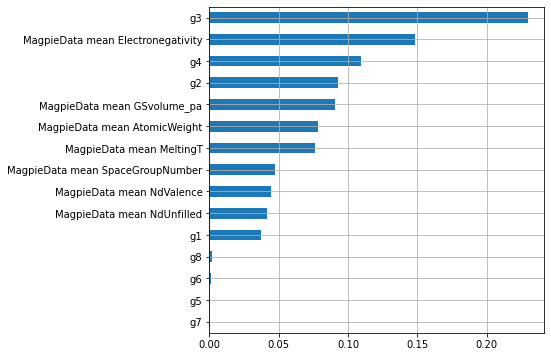

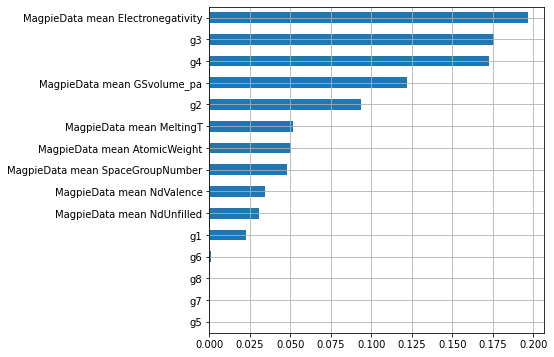

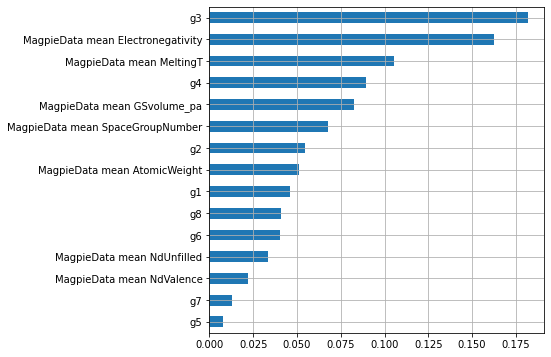

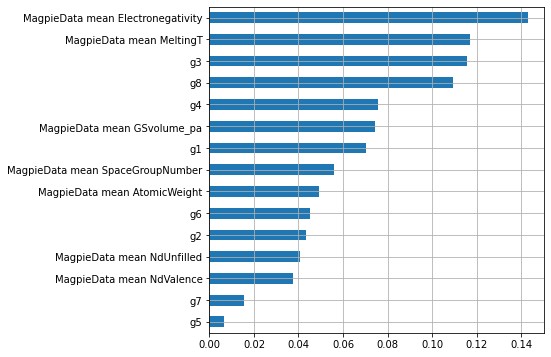

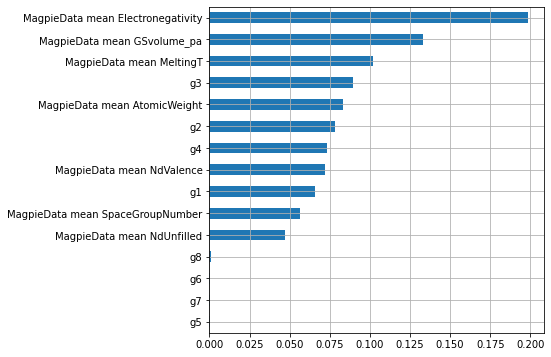

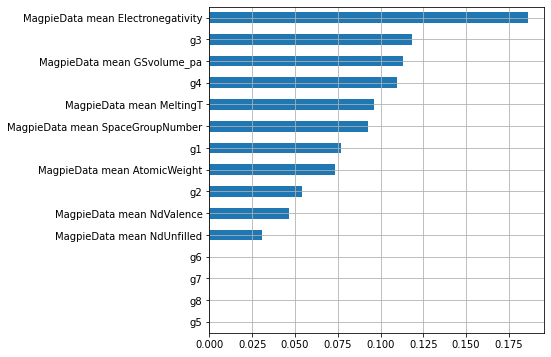

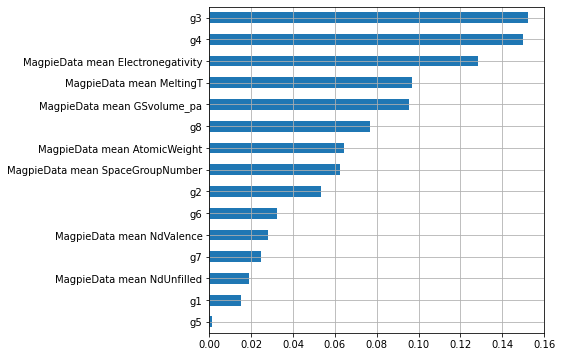

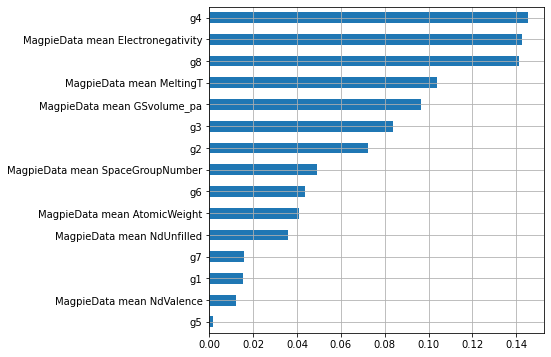

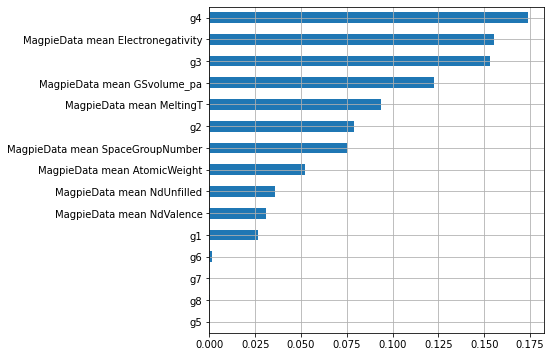

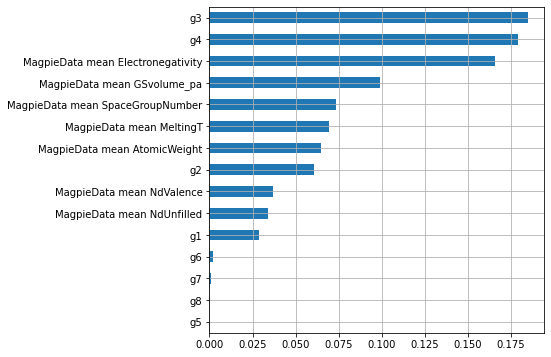

In [129]:
r_etas = [[1], [4]]
r_shift = [[1], [4]]
a_etas = [[1], [4]]
zetas = [[1], [4]]
max = 16
u = 0
t = []
print('_' * max)
for r_etas_i, r_shift_i, a_etas_i, zetas_i in product(r_etas, r_shift, a_etas, zetas):
    u += 1
    l, a, mean = GS(df = df, data_t = data_t, r_etas = r_etas_i, r_shift = r_shift_i, a_etas = a_etas_i, zetas = zetas_i)
    t.append(np.array([r_etas_i[0], r_shift_i[0], a_etas_i[0], zetas_i[0], l, a, mean]))
    print("O" * u + '_' * (max - u))

In [149]:
for r_etas_i, r_shift_i, a_etas_i, zetas_i in product(r_etas, r_shift, a_etas, zetas):
    print(r_etas_i, r_shift_i, a_etas_i, zetas_i)

[1] [1] [1] [1]
[1] [1] [1] [4]
[1] [1] [4] [1]
[1] [1] [4] [4]
[1] [4] [1] [1]
[1] [4] [1] [4]
[1] [4] [4] [1]
[1] [4] [4] [4]
[4] [1] [1] [1]
[4] [1] [1] [4]
[4] [1] [4] [1]
[4] [1] [4] [4]
[4] [4] [1] [1]
[4] [4] [1] [4]
[4] [4] [4] [1]
[4] [4] [4] [4]


In [148]:
q = []
for i in t:
    q.append([[round((i[-2][0] + i[-2][1]) / 2, 3), round((-i[-2][0] + i[-2][1]) / 2, 3)], [round((i[-1][0] + i[-1][1]) / 2, 3), round((-i[-1][0] + i[-1][1]) / 2, 3)]])
for i in range(len(q)):
    print(q[i][0], q[i][1])

[-120.709, 128.183] [-124.199, 134.122]
[-122.939, 128.358] [-125.978, 131.747]
[-121.624, 129.624] [-125.368, 131.844]
[-121.893, 124.217] [-124.273, 132.048]
[-123.765, 129.304] [-127.1, 132.24]
[-129.218, 131.008] [-127.314, 133.662]
[-126.551, 131.267] [-126.135, 131.383]
[-123.939, 127.632] [-126.619, 132.962]
[-125.766, 129.667] [-127.03, 130.275]
[-129.431, 125.814] [-124.013, 131.441]
[-124.787, 129.019] [-127.633, 131.829]
[-125.003, 129.116] [-126.023, 130.566]
[-122.759, 132.718] [-127.592, 130.964]
[-121.948, 129.254] [-126.359, 132.012]
[-123.215, 128.054] [-127.611, 132.964]
[-120.443, 130.549] [-125.901, 127.514]


In [80]:
i = df1.loc[(df1['g1'] + df1['g2'] + df1['g3'] + df1['g4'] + df1['g5'] + df1['g6'] + df1['g7'] + df1['g8']) != 0].index
df2 = df1.loc[i]
df2 = df2[['MagpieData mean AtomicWeight', 'MagpieData mean MeltingT',
'MagpieData mean Electronegativity', 'MagpieData mean NdValence', 'MagpieData mean GSvolume_pa', 
'MagpieData mean SpaceGroupNumber', 'MagpieData mean NdUnfilled', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8']]
df2 = df2[['MagpieData mean AtomicWeight', 'MagpieData mean MeltingT',
'MagpieData mean Electronegativity', 'MagpieData mean NdValence', 'MagpieData mean GSvolume_pa', 
'MagpieData mean SpaceGroupNumber', 'MagpieData mean NdUnfilled', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8']]
data_t2 = data_t1.loc[i]
df2 = (df2 - df2.mean()) / df2.std()
df2

,MagpieData mean AtomicWeight,MagpieData mean MeltingT,MagpieData mean Electronegativity,MagpieData mean NdValence,MagpieData mean GSvolume_pa,MagpieData mean SpaceGroupNumber,MagpieData mean NdUnfilled
9,-0.374090,-0.382039,-1.217882,-1.068882,2.162001,1.064047,-1.166440
10,2.227859,0.312379,-1.265952,-0.007393,1.021685,1.007759,1.499172
11,0.611328,-1.236490,0.419501,1.879698,1.494388,-0.379347,-1.166440
27,-1.174314,0.484069,0.350401,-0.479166,-1.505622,0.058898,-1.166440
28,-1.202022,-0.281502,-0.779244,-0.479166,-1.432259,0.509205,-1.166440
...,...,...,...,...,...,...,...
5764,-0.509263,-0.548835,4.232050,-1.186826,-1.322343,-2.385625,-0.166835
5766,1.362808,2.226554,0.398470,-0.479166,-0.246953,0.822811,2.165575
5767,1.106607,1.661532,2.609689,-0.597109,-0.878524,-0.204451,1.082670
5768,-0.389190,-0.581420,-1.698582,0.287465,0.478622,0.259928,1.082670


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df2, data_t2, test_size=0.2, random_state=85)

param_grid_rfr = { 
            "n_estimators"      : [10, 30, 100, 300],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }
rfr = RandomForestRegressor()
CV_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid_rfr, cv = 7)
CV_rfr.fit(X_train, y_train.values.ravel())

In [45]:
CV_rfr.best_params_

{'bootstrap': True,
 'max_features': 'log2',
 'min_samples_split': 8,
 'n_estimators': 100}

In [102]:
rfr1 = RandomForestRegressor(max_features = 'log2', min_samples_split = 8, bootstrap = True, n_estimators = 100)
rfr1.fit(X_train, y_train.values.ravel())
predictions = rfr1.predict(X_test)
predictions1 = rfr1.predict(X_train)
cross_val_score(rfr1, X_test, y_test, cv = 5).mean()

-0.1710460603822001

/usr/local/lib/python3.9/dist-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


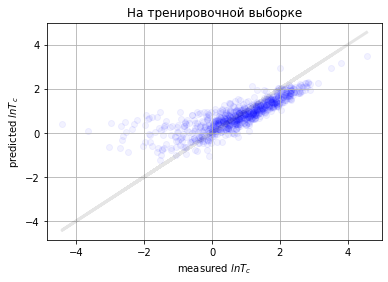

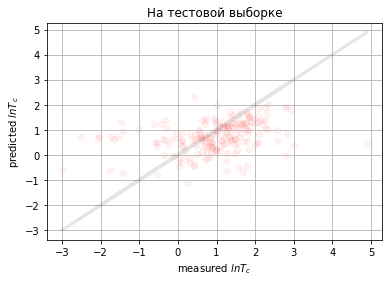

In [104]:
fig, ax = plt.subplots()
ax.grid()

plt.scatter(np.log(y_train), np.log(predictions1), color = 'blue', alpha = 0.05)
plt.plot(np.log(y_train), np.log(y_train), color = 'black', linewidth = 3, alpha = 0.1)
ax.set_xlabel('measured $ln T_c$')
ax.set_ylabel('predicted $ln T_c$')
plt.title("На тренировочной выборке")
#plt.ylim((0, 4))
plt.show()


plt.grid()
plt.scatter(np.log(y_test), np.log(predictions), color = 'red', alpha = 0.05)
plt.plot(np.log(y_test), np.log(y_test), color = 'black', linewidth = 3, alpha = 0.1)
plt.xlabel('measured $ln T_c$')
plt.ylabel('predicted $ln T_c$')
plt.title("На тестовой выборке")
#plt.ylim((0, 4))
plt.show()

In [ ]:
A1 = np.array([ 0.27396661, -0.20361566, -0.08534573,  0.02678424,  0.07094797])
A2 = np.array([-0.06527448, -0.19937755, -0.16488693,  0.07318791, -0.14152555])
A3 = np.array([ 0.23486578, -0.28774367, -0.01798805,  0.09183783,  0.16460046])
print("Только старые признаки:", "среднее:", A1.mean())
print("Только структурные признаки:", "среднее:", A2.mean())
print("Все вместе:", "среднее:", A3.mean())

Только старые признаки: среднее: 0.016547486
Только структурные признаки: среднее: -0.09957532
Все вместе: среднее: 0.03711447


In [110]:
def plot_features_scores(model, data, target, column_names, model_type):
    '''Функция для визуализации важности признаков'''
    
    model.fit(data, target)
    
    if model_type == 'rf':
        (pd.DataFrame(data={'score': model['rf'].feature_importances_}, 
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
    elif model_type == 'lr':
        (pd.DataFrame(data={'score': model['lr'].coef_[0]},
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
        
    else:
        raise KeyError('Unknown model_type')

scores = [  -6.90012246  -17.65568673  -11.85099491 -233.23622141  -10.56691959] 
mean score = -56.04199 +/- 88.66460


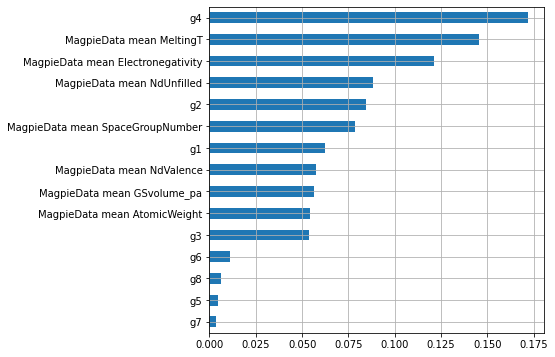

In [123]:
rf = Pipeline([('rf', rfr1)])

# параметры кросс-валидации (стратифицированная 5-фолдовая с перемешиванием) 

scores = cross_val_score(estimator=rf, X=X_test, y=y_test, scoring='neg_mean_squared_error', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

# важность признаков
plot_features_scores(model=rf, data=X_test, target=predictions, column_names=X_test.columns, model_type='rf')